In [8]:
# Cell 1
# Purpose: Import all libraries needed for preprocessing and GAN training.

import numpy as np
import mne
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

print("Libraries imported successfully.")


Libraries imported successfully.


/home/glider/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
# Cell 2
# Purpose: Define all configuration values in one place.

DATA_DIR = Path("BCICIV_2b_gdf")          # folder containing *T.gdf
T_FILES = sorted(DATA_DIR.glob("*T.gdf"))

EVENT_KEYS = {"left": "769", "right": "770"}

TMIN, TMAX = 0.0, 4.0
L_FREQ, H_FREQ = 0.5, 40.0
NOTCH_HZ = 50.0
EOG_REJECT_UV = 150.0
RESAMPLE_HZ = 250
CLIP_UV = 100.0

BATCH_SIZE = 32
EPOCHS = 200
Z_DIM = 128
LR = 1e-4
N_CRITIC = 5
LAMBDA_GP = 10.0

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("Found T files:", [f.name for f in T_FILES])
print("Training device:", DEVICE)


Found T files: ['B0101T.gdf', 'B0102T.gdf', 'B0103T.gdf', 'B0201T.gdf', 'B0202T.gdf', 'B0203T.gdf', 'B0301T.gdf', 'B0302T.gdf', 'B0303T.gdf', 'B0401T.gdf', 'B0402T.gdf', 'B0403T.gdf', 'B0501T.gdf', 'B0502T.gdf', 'B0503T.gdf', 'B0601T.gdf', 'B0602T.gdf', 'B0603T.gdf', 'B0701T.gdf', 'B0702T.gdf', 'B0703T.gdf', 'B0801T.gdf', 'B0802T.gdf', 'B0803T.gdf', 'B0901T.gdf', 'B0902T.gdf', 'B0903T.gdf']
Training device: cuda


In [13]:
# Cell 3
# Purpose: Define preprocessing for ONE T file (filter → epoch → EOG reject → drop EOG).

def preprocess_one_file(gdf_path: Path):
    raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)

    # mark EOG channels
    for ch in raw.ch_names:
        if "EOG" in ch.upper():
            raw.set_channel_types({ch: "eog"})

    # filter
    raw.filter(L_FREQ, H_FREQ, verbose=False)
    raw.notch_filter(NOTCH_HZ, verbose=False)

    # events
    events, event_id_all = mne.events_from_annotations(raw, verbose=False)

    event_id = {
        "left": event_id_all[EVENT_KEYS["left"]],
        "right": event_id_all[EVENT_KEYS["right"]],
    }

    # epoch EEG+EOG
    epochs = mne.Epochs(
        raw, events, event_id=event_id,
        tmin=TMIN, tmax=TMAX,
        picks=mne.pick_types(raw.info, eeg=True, eog=True),
        baseline=None,
        preload=True,
        verbose=False,
    )

    # EOG rejection
    eog_picks = mne.pick_types(epochs.info, eog=True)
    X = epochs.get_data()
    X_eog = X[:, eog_picks, :]
    ptp_uv = (X_eog.max(-1) - X_eog.min(-1)) * 1e6
    bad_idx = np.where(ptp_uv.max(axis=1) > EOG_REJECT_UV)[0]
    epochs.drop(bad_idx)

    # drop EOG
    epochs = epochs.pick_types(eeg=True)

    # resample
    epochs.resample(RESAMPLE_HZ, verbose=False)

    # labels → 0/1
    y = epochs.events[:, 2]
    y = np.array([0 if v == event_id["left"] else 1 for v in y])

    return epochs.get_data(), y

print("Preprocessing function defined.")


Preprocessing function defined.


In [14]:
# Cell 4
# Purpose: Apply preprocessing to all T files and concatenate epochs in memory.

X_all, y_all = [], []

for f in T_FILES:
    print("Processing:", f.name)
    X_i, y_i = preprocess_one_file(f)
    print("  epochs:", X_i.shape[0])
    X_all.append(X_i)
    y_all.append(y_i)

X = np.concatenate(X_all, axis=0)
y = np.concatenate(y_all, axis=0)

print("Final dataset shape X:", X.shape)
print("Final labels shape y:", y.shape)
print("Label counts:", {0: int((y==0).sum()), 1: int((y==1).sum())})


Processing: B0101T.gdf


/tmp/ipykernel_1907/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 3 epochs: 27, 60, 80
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 117
Processing: B0102T.gdf


/tmp/ipykernel_1907/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 2 epochs: 0, 98
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 118
Processing: B0103T.gdf


/tmp/ipykernel_1907/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 69 epochs: 1, 10, 15, 18, 20, 26, 27, 29, 30, 31, 32, 33, 35, 36, 37, 38, 41, 45, 50, 52, 54, 55, 56, 58, 60, 62, 63, 64, 65, 67, 70, 72, 75, 77, 79, 81, 82, 92, 98, 103, 106, 113, 114, 115, 117, 118, 123, 124, 127, 128, 129, 131, 132, 133, 134, 135, 137, 144, 145, 146, 150, 152, 153, 154, 155, 156, 157, 158, 159
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 91
Processing: B0201T.gdf


/tmp/ipykernel_1907/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 4 epochs: 2, 4, 18, 29
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 116
Processing: B0202T.gdf


/tmp/ipykernel_1907/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 2 epochs: 45, 52
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 118
Processing: B0203T.gdf


/tmp/ipykernel_1907/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 11 epochs: 4, 33, 91, 93, 109, 115, 117, 127, 128, 133, 138
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 149
Processing: B0301T.gdf


/tmp/ipykernel_1907/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 27 epochs: 13, 17, 24, 25, 26, 27, 31, 32, 41, 42, 45, 50, 51, 53, 55, 57, 64, 73, 76, 79, 84, 86, 89, 95, 106, 109, 116
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 93
Processing: B0302T.gdf


/tmp/ipykernel_1907/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 16 epochs: 1, 18, 25, 29, 40, 45, 49, 59, 61, 64, 87, 89, 92, 100, 112, 116
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 104
Processing: B0303T.gdf


/tmp/ipykernel_1907/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 59 epochs: 1, 2, 4, 11, 12, 16, 17, 18, 19, 20, 23, 28, 31, 36, 40, 41, 44, 45, 46, 49, 50, 51, 53, 57, 58, 59, 60, 61, 63, 67, 68, 74, 78, 83, 90, 91, 92, 93, 100, 101, 105, 108, 113, 115, 119, 120, 121, 122, 124, 129, 132, 133, 135, 137, 138, 143, 145, 150, 153
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 101
Processing: B0401T.gdf


/tmp/ipykernel_1907/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 37 epochs: 1, 2, 3, 4, 7, 19, 25, 27, 29, 31, 38, 39, 40, 48, 50, 56, 58, 71, 72, 74, 76, 77, 83, 89, 91, 92, 94, 95, 97, 98, 102, 103, 104, 112, 116, 118, 119
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 83
Processing: B0402T.gdf


/tmp/ipykernel_1907/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 17 epochs: 25, 33, 36, 51, 63, 84, 88, 92, 101, 109, 110, 117, 118, 119, 124, 131, 134
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 123
Processing: B0403T.gdf


/tmp/ipykernel_1907/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 16 epochs: 7, 14, 16, 18, 35, 45, 57, 61, 62, 76, 89, 103, 109, 135, 140, 153
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 144
Processing: B0501T.gdf


/tmp/ipykernel_1907/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 1 epoch: 30
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 119
Processing: B0502T.gdf


/tmp/ipykernel_1907/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 28 epochs: 0, 4, 8, 9, 10, 25, 40, 50, 51, 54, 57, 78, 94, 95, 96, 98, 101, 102, 103, 106, 115, 122, 126, 128, 129, 132, 134, 139
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 112
Processing: B0503T.gdf


/tmp/ipykernel_1907/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 67 epochs: 2, 4, 5, 6, 7, 11, 13, 15, 16, 17, 20, 21, 22, 23, 24, 26, 27, 29, 33, 37, 43, 48, 49, 50, 53, 55, 56, 58, 61, 62, 64, 65, 67, 68, 79, 81, 82, 84, 88, 90, 104, 107, 112, 115, 117, 123, 125, 126, 128, 130, 132, 133, 134, 136, 137, 138, 139, 140, 141, 143, 144, 146, 149, 151, 156, 157, 158
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 93
Processing: B0601T.gdf


/tmp/ipykernel_1907/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 15 epochs: 8, 9, 10, 14, 15, 17, 18, 19, 22, 34, 48, 52, 53, 104, 118
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 105
Processing: B0602T.gdf


/tmp/ipykernel_1907/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 6 epochs: 22, 26, 33, 44, 82, 89
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 114
Processing: B0603T.gdf


/tmp/ipykernel_1907/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 7 epochs: 21, 36, 37, 46, 129, 132, 137
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 153
Processing: B0701T.gdf


/tmp/ipykernel_1907/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 10 epochs: 0, 2, 4, 5, 11, 59, 68, 77, 99, 102
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 110
Processing: B0702T.gdf


/tmp/ipykernel_1907/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 10 epochs: 15, 22, 27, 28, 31, 57, 58, 108, 110, 119
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 110
Processing: B0703T.gdf


/tmp/ipykernel_1907/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 31 epochs: 3, 18, 29, 47, 56, 62, 73, 74, 78, 79, 83, 86, 87, 90, 91, 97, 102, 103, 108, 111, 115, 116, 120, 123, 124, 139, 149, 151, 152, 153, 157
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 129
Processing: B0801T.gdf


/tmp/ipykernel_1907/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 105 epochs: 0, 4, 5, 6, 8, 10, 11, 15, 17, 18, 23, 25, 29, 30, 32, 33, 35, 36, 37, 40, 41, 42, 45, 46, 47, 48, 49, 50, 52, 54, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 85, 86, 87, 88, 90, 93, 96, 97, 98, 99, 100, 101, 103, 104, 105, 106, 107, 108, 109, 111, 113, 114, 115, 116, 117, 118, 120, 121, 122, 124, 125, 126, 127, 128, 133, 134, 135, 136, 137, 138, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 156
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 55
Processing: B0802T.gdf


/tmp/ipykernel_1907/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 72 epochs: 0, 2, 3, 4, 6, 7, 14, 15, 16, 17, 19, 20, 21, 22, 24, 29, 32, 33, 34, 35, 38, 41, 43, 46, 56, 57, 58, 60, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 78, 79, 80, 81, 82, 84, 88, 89, 90, 92, 93, 97, 98, 99, 101, 102, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 116, 117, 118, 119
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 48
Processing: B0803T.gdf


/tmp/ipykernel_1907/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 17 epochs: 0, 4, 6, 20, 43, 47, 55, 61, 63, 119, 147, 150, 152, 153, 157, 158, 159
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 143
Processing: B0901T.gdf


/tmp/ipykernel_1907/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 3 epochs: 55, 71, 104
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 117
Processing: B0902T.gdf


/tmp/ipykernel_1907/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 3 epochs: 29, 67, 109
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 117
Processing: B0903T.gdf


/tmp/ipykernel_1907/521044987.py:5: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)


Dropped 8 epochs: 10, 11, 49, 60, 97, 109, 142, 157
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  epochs: 152
Final dataset shape X: (3034, 3, 1001)
Final labels shape y: (3034,)
Label counts: {0: 1524, 1: 1510}


In [15]:
# Cell 5
# Purpose: Convert EEG to GAN-friendly scale [-1, 1].

X = X * 1e6                # volts → microvolts
X = np.clip(X, -CLIP_UV, CLIP_UV)
X = (X / CLIP_UV).astype(np.float32)

print("After normalization:")
print("  min:", X.min(), "max:", X.max())
print("  dtype:", X.dtype)


After normalization:
  min: -1.0 max: 0.48452762
  dtype: float32


In [16]:
# Cell 6
# Purpose: Wrap EEG data into PyTorch Dataset and DataLoader.

class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = EEGDataset(X, y)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

xb, yb = next(iter(loader))
print("One batch shape:", xb.shape)
print("Batch labels:", yb[:10].tolist())


One batch shape: torch.Size([32, 3, 1001])
Batch labels: [1, 0, 1, 1, 1, 1, 0, 1, 1, 1]


In [18]:
# Cell 7
# Purpose: Define a simple conditional Generator (standard WGAN-GP).

class Generator(nn.Module):
    def __init__(self, z_dim, n_classes, C, T):
        super().__init__()
        self.embed = nn.Embedding(n_classes, z_dim)
        self.net = nn.Sequential(
            nn.Linear(z_dim, 512),
            nn.ReLU(),
            nn.Linear(512, C * T),
            nn.Tanh(),
        )
        self.C, self.T = C, T

    def forward(self, z, y):
        z = z + self.embed(y)
        return self.net(z).view(-1, self.C, self.T)

print("Generator defined.")


Generator defined.


In [19]:
# Cell 8
# Purpose: Define the Critic (Discriminator) for WGAN-GP.

class Critic(nn.Module):
    def __init__(self, n_classes, C, T):
        super().__init__()
        self.embed = nn.Embedding(n_classes, C * T)
        self.net = nn.Sequential(
            nn.Linear(C * T, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1),
        )

    def forward(self, x, y):
        x = x.view(x.size(0), -1)
        x = x + self.embed(y)
        return self.net(x)

print("Critic defined.")


Critic defined.


In [20]:
# Cell 9
# Purpose: Implement gradient penalty (standard WGAN-GP).

def gradient_penalty(D, real, fake, y):
    alpha = torch.rand(real.size(0), 1, 1, device=DEVICE)
    interp = alpha * real + (1 - alpha) * fake
    interp.requires_grad_(True)

    d_interp = D(interp, y)
    grads = torch.autograd.grad(
        outputs=d_interp,
        inputs=interp,
        grad_outputs=torch.ones_like(d_interp),
        create_graph=True,
    )[0]

    return ((grads.norm(2, dim=1) - 1) ** 2).mean()

print("Gradient penalty function ready.")


Gradient penalty function ready.


In [21]:
# Cell 10
# Purpose: Initialize Generator, Critic, and optimizers.

C, T = X.shape[1], X.shape[2]

G = Generator(Z_DIM, 2, C, T).to(DEVICE)
D = Critic(2, C, T).to(DEVICE)

opt_G = torch.optim.Adam(G.parameters(), lr=LR, betas=(0.5, 0.9))
opt_D = torch.optim.Adam(D.parameters(), lr=LR, betas=(0.5, 0.9))

print("Models initialized on device:", DEVICE)


Models initialized on device: cuda


In [23]:
# Cell 11
# Purpose: Setup checkpoint saving (self-contained so later cells won't NameError)

from pathlib import Path

SAVE_DIR = Path("./checkpoints")
SAVE_DIR.mkdir(exist_ok=True)

def save_models(epoch, G, D, opt_G, opt_D, save_dir):
    path = save_dir / f"wgan_gp_epoch_{epoch:04d}.pt"
    torch.save(
        {
            "epoch": epoch,
            "generator_state": G.state_dict(),
            "critic_state": D.state_dict(),
            "opt_G_state": opt_G.state_dict(),
            "opt_D_state": opt_D.state_dict(),
        },
        path,
    )
    return path  # return path so we can show it in tqdm without printing a lot

print("Checkpoint directory:", SAVE_DIR.resolve())


Checkpoint directory: /home/glider/gans_eeg/normal_gans/checkpoints


In [27]:
# Cell 12
# Purpose: Train standard conditional WGAN-GP with tqdm progress bars (no noisy prints), saving checkpoints.

from tqdm.auto import tqdm
import numpy as np

D_loss_history = []
G_loss_history = []

SAVE_EVERY = 25  # save every N epochs

epoch_bar = tqdm(range(EPOCHS), desc="Training Epochs")

for epoch in epoch_bar:
    d_losses, g_losses = [], []

    batch_bar = tqdm(loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)

    for x_real, y_real in batch_bar:
        x_real, y_real = x_real.to(DEVICE), y_real.to(DEVICE)

        # ---- Train Critic ----
        for _ in range(N_CRITIC):
            z = torch.randn(x_real.size(0), Z_DIM, device=DEVICE)
            x_fake = G(z, y_real).detach()

            loss_D = (
                D(x_fake, y_real).mean()
                - D(x_real, y_real).mean()
                + LAMBDA_GP * gradient_penalty(D, x_real, x_fake, y_real)
            )

            opt_D.zero_grad(set_to_none=True)
            loss_D.backward()
            opt_D.step()

        # ---- Train Generator ----
        z = torch.randn(x_real.size(0), Z_DIM, device=DEVICE)
        x_fake = G(z, y_real)

        loss_G = -D(x_fake, y_real).mean()

        opt_G.zero_grad(set_to_none=True)
        loss_G.backward()
        opt_G.step()

        d_losses.append(loss_D.item())
        g_losses.append(loss_G.item())

        # lightweight live update
        batch_bar.set_postfix(D=float(np.mean(d_losses)), G=float(np.mean(g_losses)))

    # epoch summary
    mean_d = float(np.mean(d_losses)) if d_losses else float("nan")
    mean_g = float(np.mean(g_losses)) if g_losses else float("nan")
    epoch_bar.set_postfix(D_loss=mean_d, G_loss=mean_g)

    # store loss history
    D_loss_history.append(mean_d)
    G_loss_history.append(mean_g)

    # ---- Save checkpoint (no spam printing) ----
    if (epoch + 1) % SAVE_EVERY == 0 or epoch == 0:
        saved_path = save_models(epoch + 1, G, D, opt_G, opt_D, SAVE_DIR)
        epoch_bar.set_postfix(D_loss=mean_d, G_loss=mean_g, saved=saved_path.name)


Training Epochs: 100%|██████████| 200/200 [10:14<00:00,  3.07s/it, D_loss=-0.145, G_loss=0.128, saved=wgan_gp_epoch_0200.pt]


In [28]:
# Cell 13
# Purpose: Verify saved checkpoints (visual confirmation).

ckpts = sorted(SAVE_DIR.glob("*.pt"))
print(f"Total checkpoints saved: {len(ckpts)}")
for p in ckpts[:5]:
    print(" -", p.name)
if len(ckpts) > 5:
    print(" ...")
    print(" -", ckpts[-1].name, "(latest)")


Total checkpoints saved: 9
 - wgan_gp_epoch_0001.pt
 - wgan_gp_epoch_0025.pt
 - wgan_gp_epoch_0050.pt
 - wgan_gp_epoch_0075.pt
 - wgan_gp_epoch_0100.pt
 ...
 - wgan_gp_epoch_0200.pt (latest)


In [29]:
from pathlib import Path

for f in Path("./checkpoints").glob("*.pt"):
    print(f)


checkpoints/wgan_gp_epoch_0075.pt
checkpoints/wgan_gp_epoch_0150.pt
checkpoints/wgan_gp_epoch_0001.pt
checkpoints/wgan_gp_epoch_0025.pt
checkpoints/wgan_gp_epoch_0125.pt
checkpoints/wgan_gp_epoch_0175.pt
checkpoints/wgan_gp_epoch_0100.pt
checkpoints/wgan_gp_epoch_0050.pt
checkpoints/wgan_gp_epoch_0200.pt


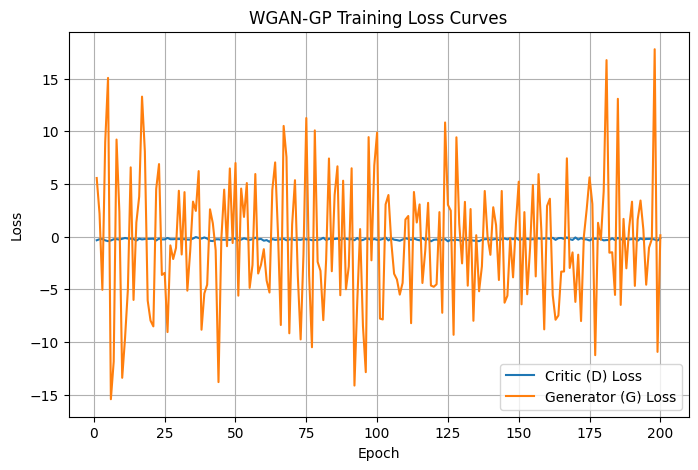

Total epochs plotted: 200


In [30]:
# Cell 14
# Purpose: Plot Generator and Critic loss curves over training epochs.

import matplotlib.pyplot as plt

epochs = range(1, len(D_loss_history) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, D_loss_history, label="Critic (D) Loss")
plt.plot(epochs, G_loss_history, label="Generator (G) Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("WGAN-GP Training Loss Curves")
plt.legend()
plt.grid(True)

plt.show()

print("Total epochs plotted:", len(epochs))


Loaded checkpoint: wgan_gp_epoch_0200.pt | epoch: 200
Will generate: {'left': 1, 'right': 1}
Expected output shape per sample: (3, 1001) (C, T)
Generated shapes:
  left : (1, 3, 1001)
  right: (1, 3, 1001)
Value ranges (µV):
  left : min -10.577022552490234 max 8.674874305725098
  right: min -9.275492668151855 max 8.433708190917969


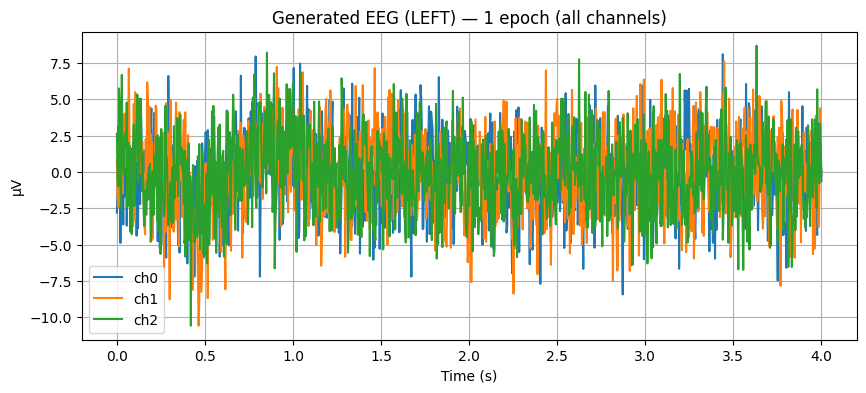

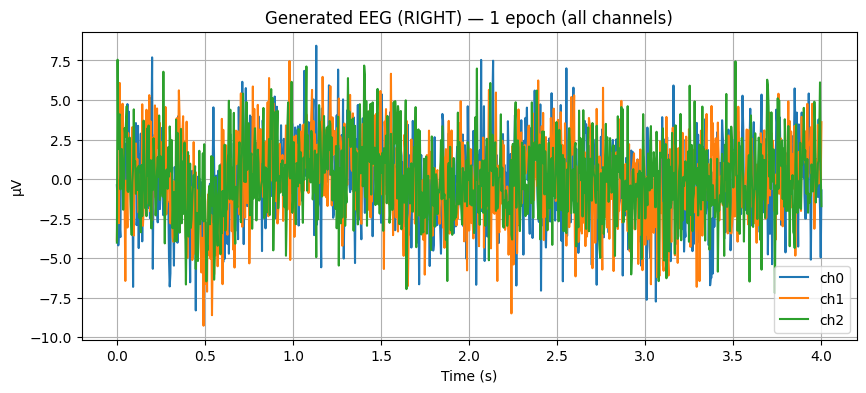

In [34]:
# Cell 15
# Purpose: Load a saved checkpoint (Generator) and generate synthetic EEG epochs for left/right.
# Output: Prints shapes + shows one example waveform (all channels) for left and right.

import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ---- User controls ----
CKPT_PATH = Path("./checkpoints") / "wgan_gp_epoch_0200.pt"  # change to your checkpoint file
N_LEFT = 1   # how many left epochs to generate (change anytime)
N_RIGHT = 1  # how many right epochs to generate (change anytime)

# ---- Load checkpoint ----
ckpt = torch.load(CKPT_PATH, map_location=DEVICE)
G.load_state_dict(ckpt["generator_state"])
G.eval()

print("Loaded checkpoint:", CKPT_PATH.name, "| epoch:", ckpt.get("epoch", "unknown"))
print("Will generate:", {"left": N_LEFT, "right": N_RIGHT})
print("Expected output shape per sample:", (X.shape[1], X.shape[2]), "(C, T)")

# ---- Generate helper ----
@torch.no_grad()
def generate_epochs(n, label01: int):
    y = torch.full((n,), label01, dtype=torch.long, device=DEVICE)   # 0=left, 1=right
    z = torch.randn(n, Z_DIM, device=DEVICE)
    x = G(z, y)  # (n, C, T) in [-1,1]
    return x.detach().cpu().numpy()

# ---- Generate ----
X_fake_left  = generate_epochs(N_LEFT, 0)
X_fake_right = generate_epochs(N_RIGHT, 1)

print("Generated shapes:")
print("  left :", X_fake_left.shape)
print("  right:", X_fake_right.shape)

# ---- Convert back to microvolts for interpretability ----
# Your training normalized data to [-1,1] using CLIP_UV, so undo scaling:
X_fake_left_uv  = X_fake_left  * CLIP_UV
X_fake_right_uv = X_fake_right * CLIP_UV

print("Value ranges (µV):")
print("  left : min", float(X_fake_left_uv.min()),  "max", float(X_fake_left_uv.max()))
print("  right: min", float(X_fake_right_uv.min()), "max", float(X_fake_right_uv.max()))

# ---- Visualize 1 sample from each class (all channels) ----
t = np.linspace(TMIN, TMAX, X_fake_left_uv.shape[2])

def plot_one(epoch_uv, title):
    plt.figure(figsize=(10, 4))
    for ch in range(epoch_uv.shape[0]):
        plt.plot(t, epoch_uv[ch], label=f"ch{ch}")
    plt.xlabel("Time (s)")
    plt.ylabel("µV")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_one(X_fake_left_uv[0],  "Generated EEG (LEFT) — 1 epoch (all channels)")
plot_one(X_fake_right_uv[0], "Generated EEG (RIGHT) — 1 epoch (all channels)")


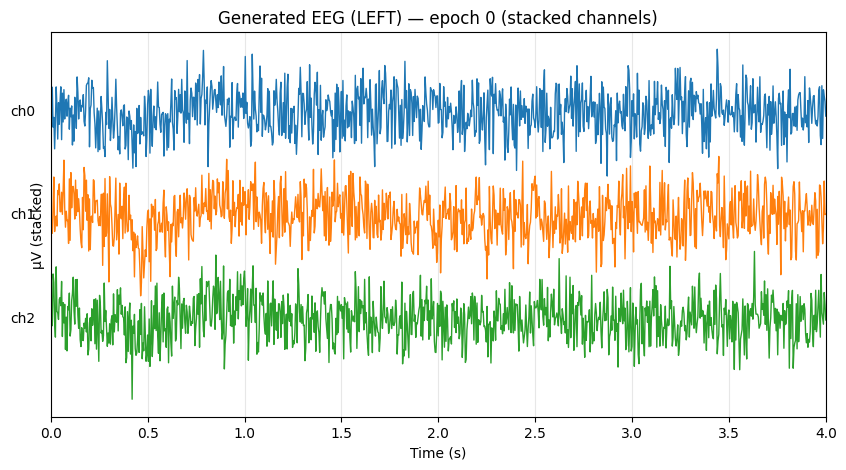

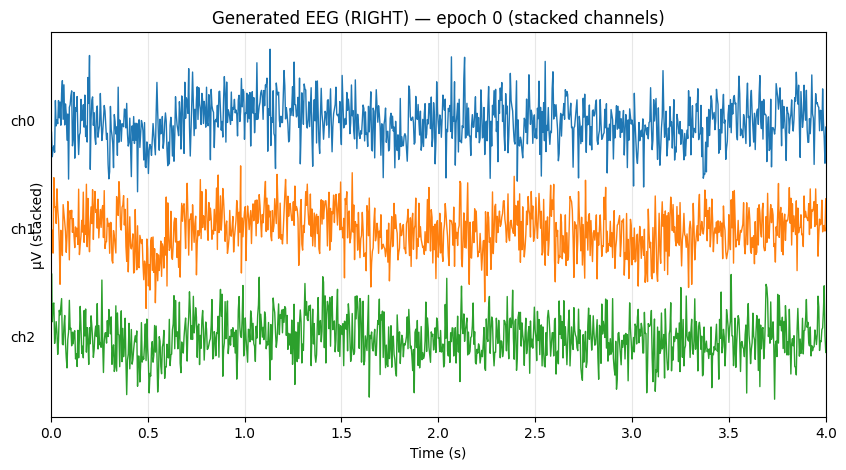

In [35]:
# Cell 16
# Purpose: Plot generated EEG like MNE (channels separated, not overlapping).
# Output: Two stacked plots (LEFT and RIGHT), each channel on its own horizontal line.

import numpy as np
import matplotlib.pyplot as plt

# ---- choose which sample to display ----
IDX_LEFT = 0
IDX_RIGHT = 0

# Use the arrays created in Cell 15:
# X_fake_left_uv  : (N_left,  C, T) in microvolts
# X_fake_right_uv : (N_right, C, T) in microvolts

t = np.linspace(TMIN, TMAX, X_fake_left_uv.shape[2])

# Try to use real channel names if you have them; otherwise fallback
try:
    ch_names = epochs_eeg.ch_names  # if you still have epochs_eeg in memory
except Exception:
    ch_names = [f"ch{i}" for i in range(X_fake_left_uv.shape[1])]

def plot_stacked(epoch_uv: np.ndarray, title: str, sep_uv: float = None):
    """
    epoch_uv: (C, T) in microvolts
    sep_uv: vertical separation between channels in microvolts (auto if None)
    """
    C, Tn = epoch_uv.shape

    # Auto separation: based on robust amplitude so it doesn't overlap
    if sep_uv is None:
        robust_amp = np.percentile(np.abs(epoch_uv), 95)  # typical large amplitude
        sep_uv = max(robust_amp * 2.5, 5.0)               # at least 5 µV spacing

    offsets = np.arange(C)[::-1] * sep_uv  # top channel highest offset

    plt.figure(figsize=(10, 5))
    for i in range(C):
        y = epoch_uv[i] + offsets[i]
        plt.plot(t, y, linewidth=1.0)

        # channel label on the left
        plt.text(t[0] - 0.02*(TMAX - TMIN), offsets[i], ch_names[i],
                 va="center", ha="right")

    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("µV (stacked)")
    plt.yticks([])  # hide y ticks because offsets are arbitrary
    plt.grid(True, alpha=0.3)
    plt.xlim(TMIN, TMAX)
    plt.show()

# ---- Plot LEFT and RIGHT (stacked) ----
plot_stacked(X_fake_left_uv[IDX_LEFT],  f"Generated EEG (LEFT) — epoch {IDX_LEFT} (stacked channels)")
plot_stacked(X_fake_right_uv[IDX_RIGHT], f"Generated EEG (RIGHT) — epoch {IDX_RIGHT} (stacked channels)")
